In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from MIOFlow.losses import MMD_loss, OT_loss, Density_loss, Local_density_loss
from MIOFlow.utils import group_extract, sample, to_np, generate_steps, \
    set_seeds, config_hold_out, config_criterion
from MIOFlow.models import ToyModel, make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train, train_ae
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data, relabel_data
)
from MIOFlow.ode import NeuralODE, ODEF
from MIOFlow.geo import  DiffusionDistance, old_DiffusionDistance, setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
from phate import PHATE
import time, pickle, random

# for geodesic learning
from sklearn.gaussian_process.kernels import RBF
from sklearn.manifold import MDS

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [ ]:
phate_dims = 5
round_labels=True
use_gaussian=False
add_noise_directly=False
add_noise_after_phate=False
scale_factor=1 if not add_noise_after_phate else 30
n_bins=5
column='d1'

In [ ]:
df = make_dyngen_data(
    time_col='sim_time', phate_dims=phate_dims, round_labels=round_labels,
    use_gaussian=use_gaussian, add_noise=add_noise_directly, 
    add_noise_after_phate=add_noise_after_phate, scale_factor=scale_factor, n_bins=n_bins, column=column
)

Calculating PHATE...
  Running PHATE on 1000 observations and 135 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.10 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.15 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.45 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 22.62 seconds.
Calculated PHATE in 23.37 seconds.


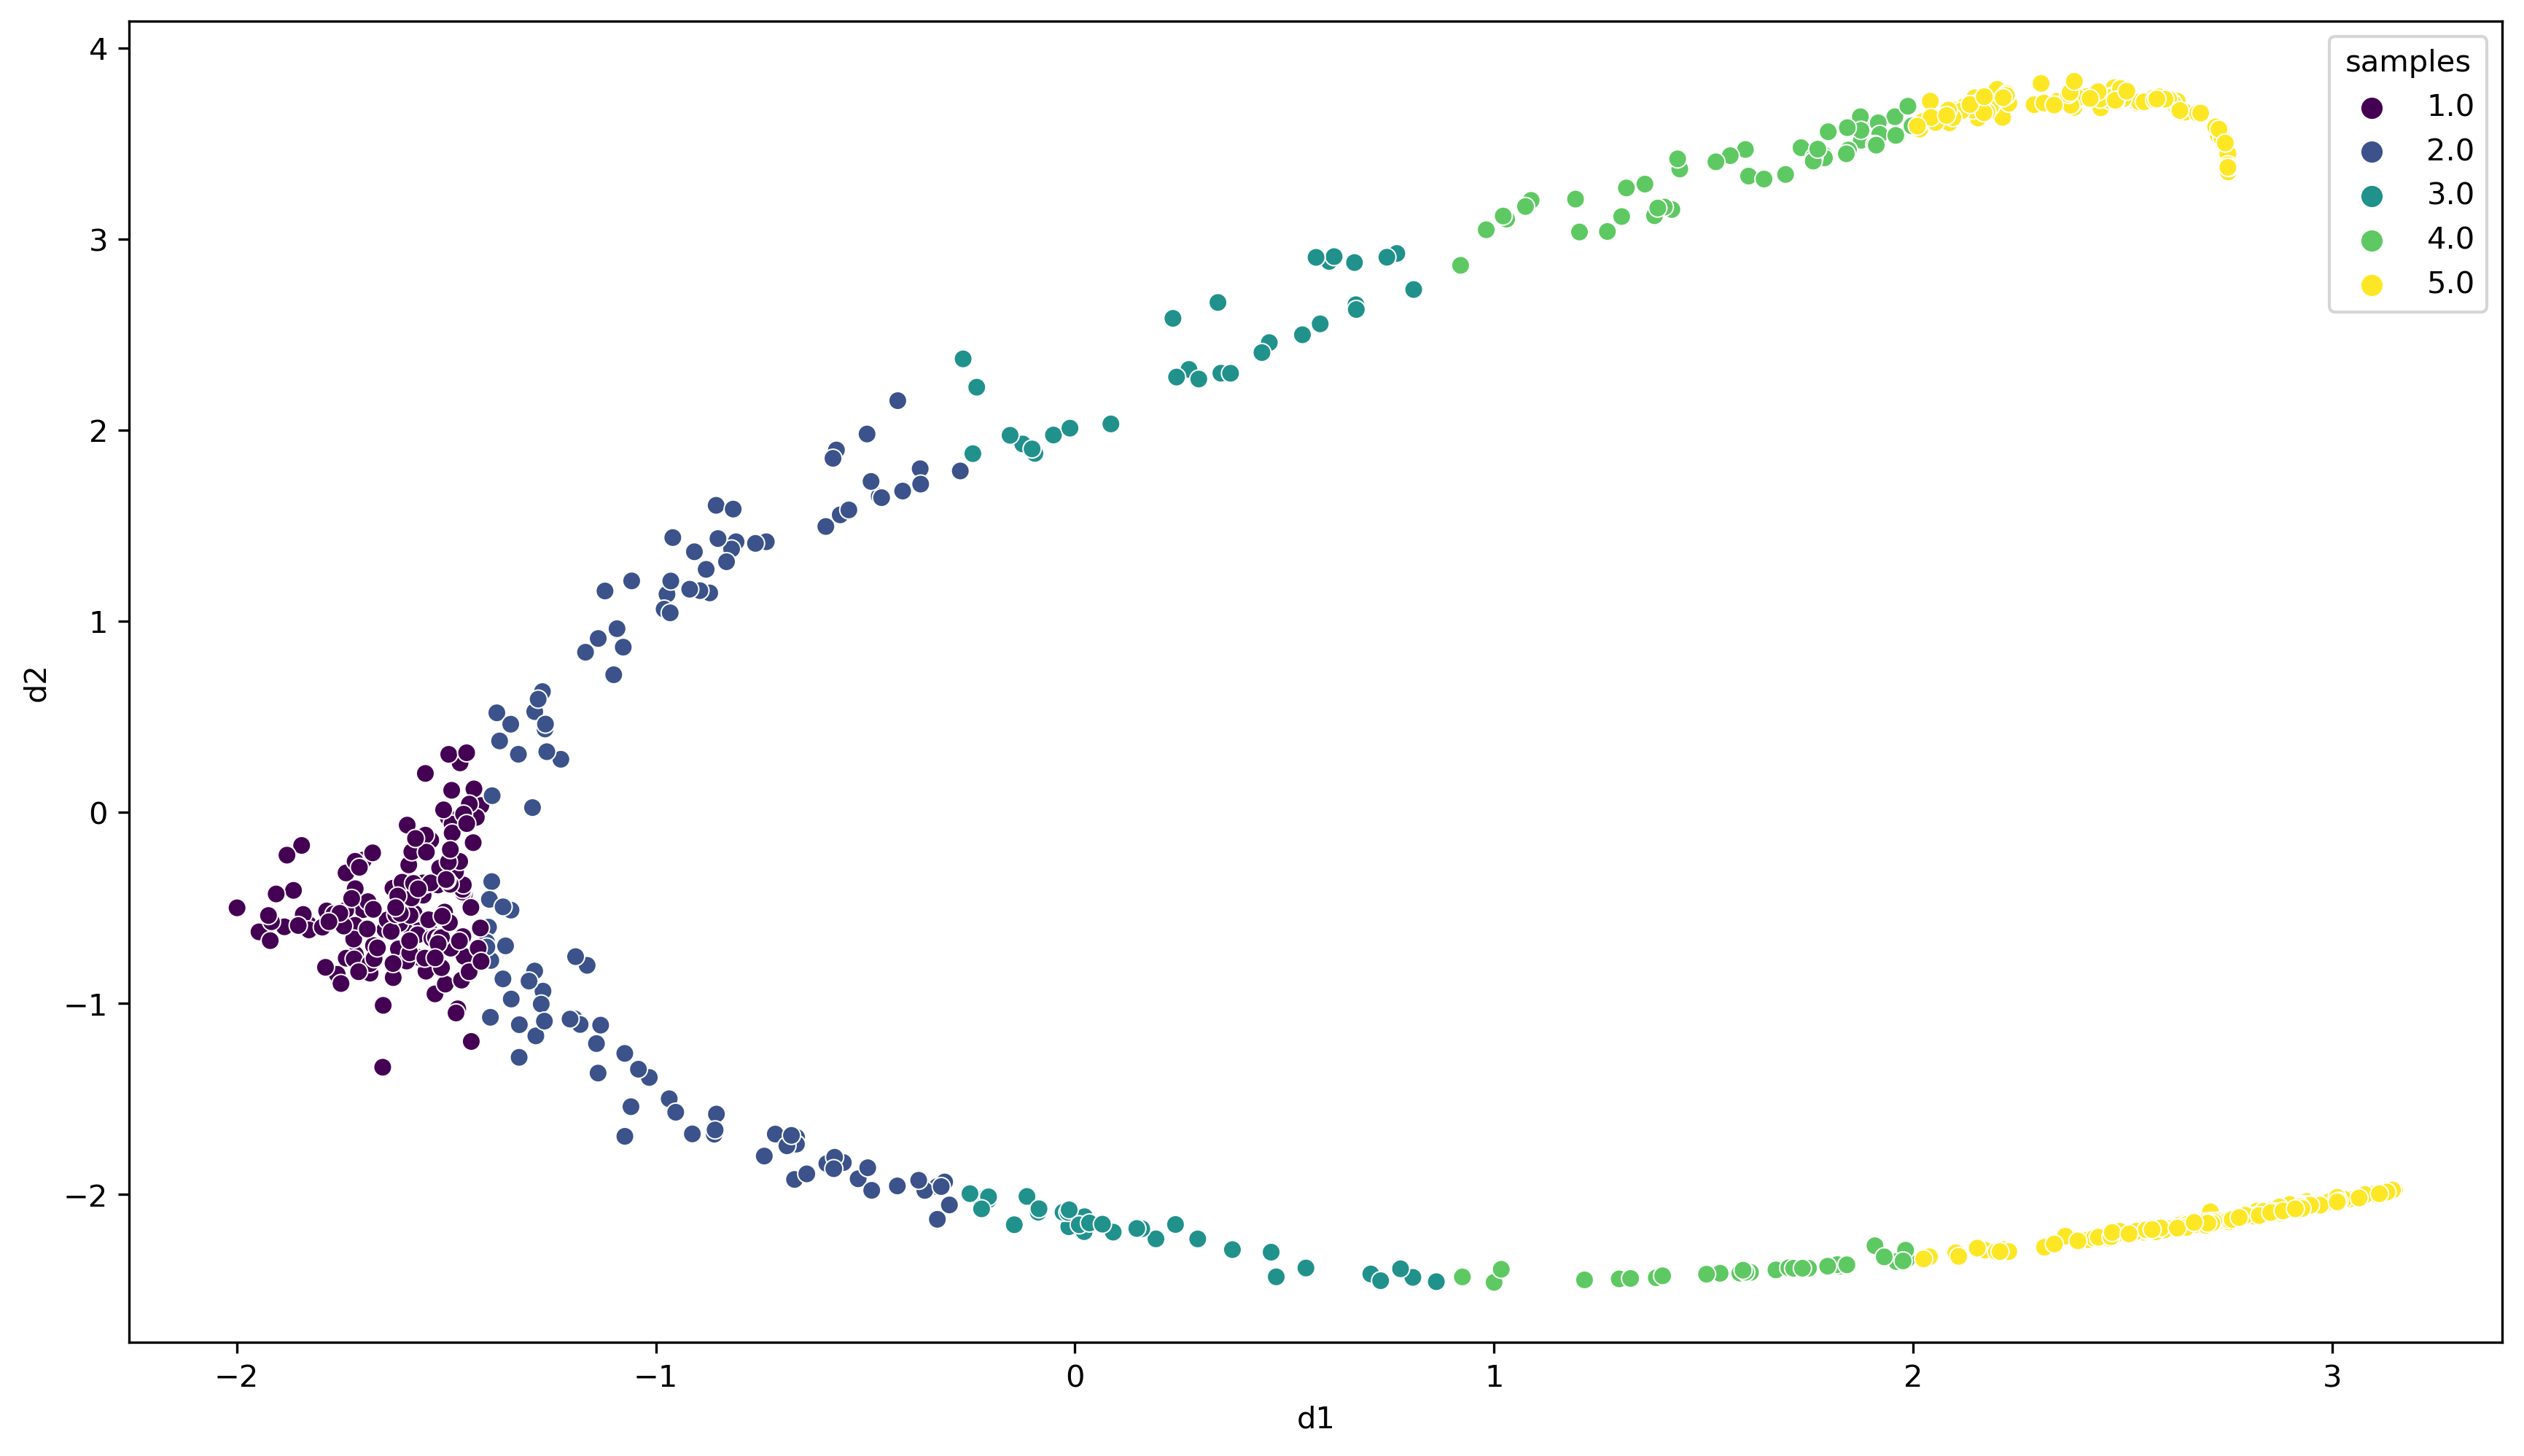

In [ ]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [ ]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [ ]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = True
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [ ]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = True

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 


# These are training GAE hyperparameters needed for training

# Distance_type in ['gaussian', 'alpha_decay']
distance_type = 'gaussian'
# Kernel parameters, rarely changed them except for rbf_length_scale.
rbf_length_scale=0.5
t_max=5
knn=5
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale, t_max=t_max, knn=knn)
     
n_epochs_emb = 1000
samples_size_emb = (30, )


# Layers for the Geodesic Autoencoder
gae_embedded_dim = 32
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the thing

In [ ]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss recon: 2.05216
Train loss dist: 6.5951
Train loss recon: 1.67234
Train loss dist: 1.40409
Train loss recon: 1.41096
Train loss dist: 1.25074
Train loss recon: 1.03987
Train loss dist: 1.09457
Train loss recon: 0.69532
Train loss dist: 0.77041
Train loss recon: 0.36111
Train loss dist: 0.67296
Train loss recon: 0.20214
Train loss dist: 0.52704
Train loss recon: 0.13164
Train loss dist: 0.40279
Train loss recon: 0.08348
Train loss dist: 0.43267
Train loss recon: 0.08989
Train loss dist: 0.43648
Train loss recon: 0.0624
Train loss dist: 0.45182
Train loss recon: 0.05437
Train loss dist: 0.40997
Train loss recon: 0.07009
Train loss dist: 0.37097
Train loss recon: 0.05558
Train loss dist: 0.44403
Train loss recon: 0.05864
Train loss dist: 0.39039
Train loss recon: 0.04833
Train loss dist: 0.37201
Train loss recon: 0.03999
Train loss dist: 0.39683
Train loss recon: 0.0399
Train loss dist: 0.34601
Train loss recon: 0.04243
Train loss dist: 0.38867
Train loss recon: 0.03316
Train lo

# Specify parameters

In [ ]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# Parameters we usually modify.
# ----------------------------------------
# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 15

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'


# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]


# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.2] 


# Parameters to never really modify
# ----------------------------------------
use_penalty_energy=False
# Coefficient associated to energy_penalty
lambda_energy = 0.01
# KNN for the density loss
top_k=5
# Hinge value for the density loss
hinge_value = 0.01
# ODE solver, can use any from torchdiffeq
ode_method = 'rk4'
# Number of extra features in dataset set to add when training the ODE
n_aug=2
# Aadding random noise to data
add_noise = False
noise_scale = 0.09 
use_gaussian = False # <-- whether or not to use gaussian to generate noise

if recon:    
    model_features = gae_embedded_dim


model = make_model(
    model_features, layers, 
    activation=activation, method=ode_method, 
    rtol=0.001, atol=0.001, scales=sde_scales, 
    n_aug=n_aug, use_norm=use_penalty_energy, use_cuda=use_cuda
)

In [ ]:
# Augment batches with same data if needed
sample_with_replacement = False

# Basically "batch size"
sample_size=(60, )

# Training specification
n_local_epochs = 2
n_epochs = 2
n_post_local_epochs = 0

criterion_name = 'ot'
criterion = config_criterion(criterion_name)
# We default this to 20 in all notebooks so can be set as default in 
# train function
n_batches = 20

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}


# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [ ]:
opts = {
    'phate_dims': phate_dims,
    'round_labels': round_labels,
    'use_gaussian': use_gaussian,
    'add_noise_directly': add_noise_directly,
    'add_noise_after_phate': add_noise_after_phate,
    'scale_factor': scale_factor,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_with_replacement': sample_with_replacement,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'n_batches': n_batches,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'hinge_value': hinge_value,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'add_noise': add_noise,
    'noise_scale': noise_scale,
    'use_gaussian': use_gaussian,
    'autoencoder': autoencoder,
    'activation': activation,
    'layer': layers,
    'ode_solver': ode_method,
    'lambda_density':lambda_density,
    'top_k':top_k,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'n_augmented_ode': n_aug,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'use_penalty_energy':use_penalty_energy,
    'lambda_energy':lambda_energy,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    't_max':t_max,
    'knn':knn
}

In [ ]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [ ]:
start_time = time.time()
for epoch in tqdm(range(n_local_epochs), desc='Pretraining Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=True, global_loss=False, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, top_k = top_k, lambda_density = lambda_density,  lambda_density_local = 1.0, 
        autoencoder = autoencoder, use_emb = use_emb, use_gae = use_gae, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian, use_penalty=use_penalty_energy,lambda_energy=lambda_energy

    )
    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
    
for epoch in tqdm(range(n_epochs), desc='Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=False, global_loss=True, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, top_k = top_k, lambda_density = lambda_density, lambda_density_local = 1.0, 
        autoencoder = autoencoder, use_emb = use_emb, use_gae = use_gae, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian,use_penalty=use_penalty_energy,lambda_energy=lambda_energy
    )

    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
    
for epoch in tqdm(range(n_post_local_epochs), desc='Posttraining Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=True, global_loss=False, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, top_k = top_k, lambda_density = lambda_density,  lambda_density_local = 1.0, 
        autoencoder = autoencoder, use_emb = use_emb, use_gae = use_gae, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian,use_penalty=use_penalty_energy,lambda_energy=lambda_energy
    )
    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

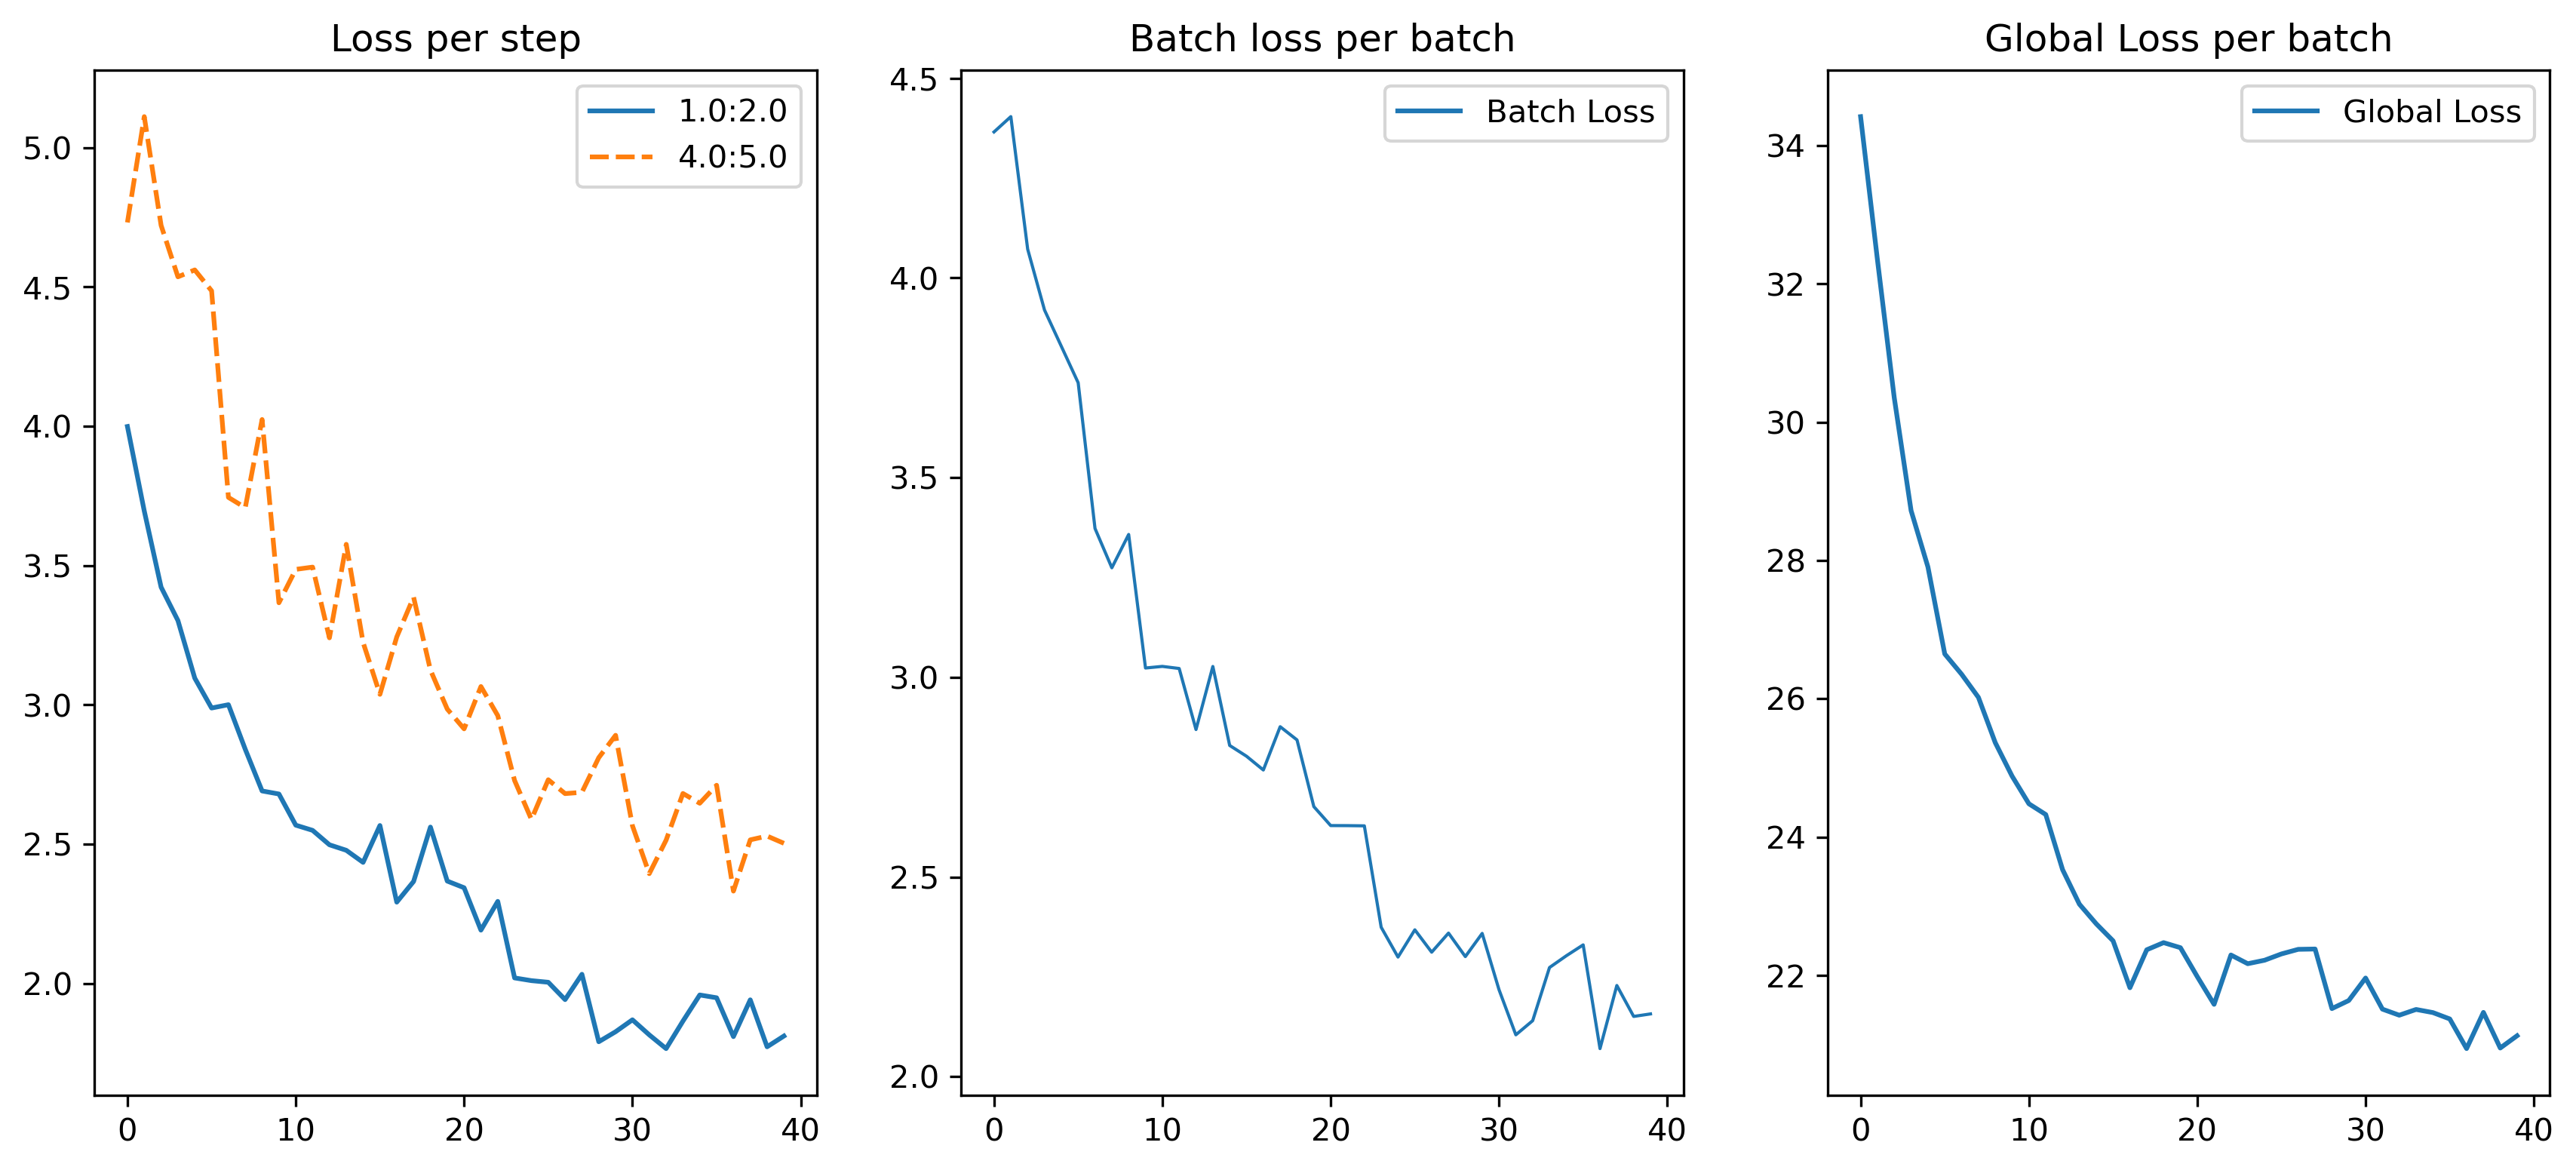

In [ ]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [ ]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, 
    sample_with_replacement=sample_with_replacement, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

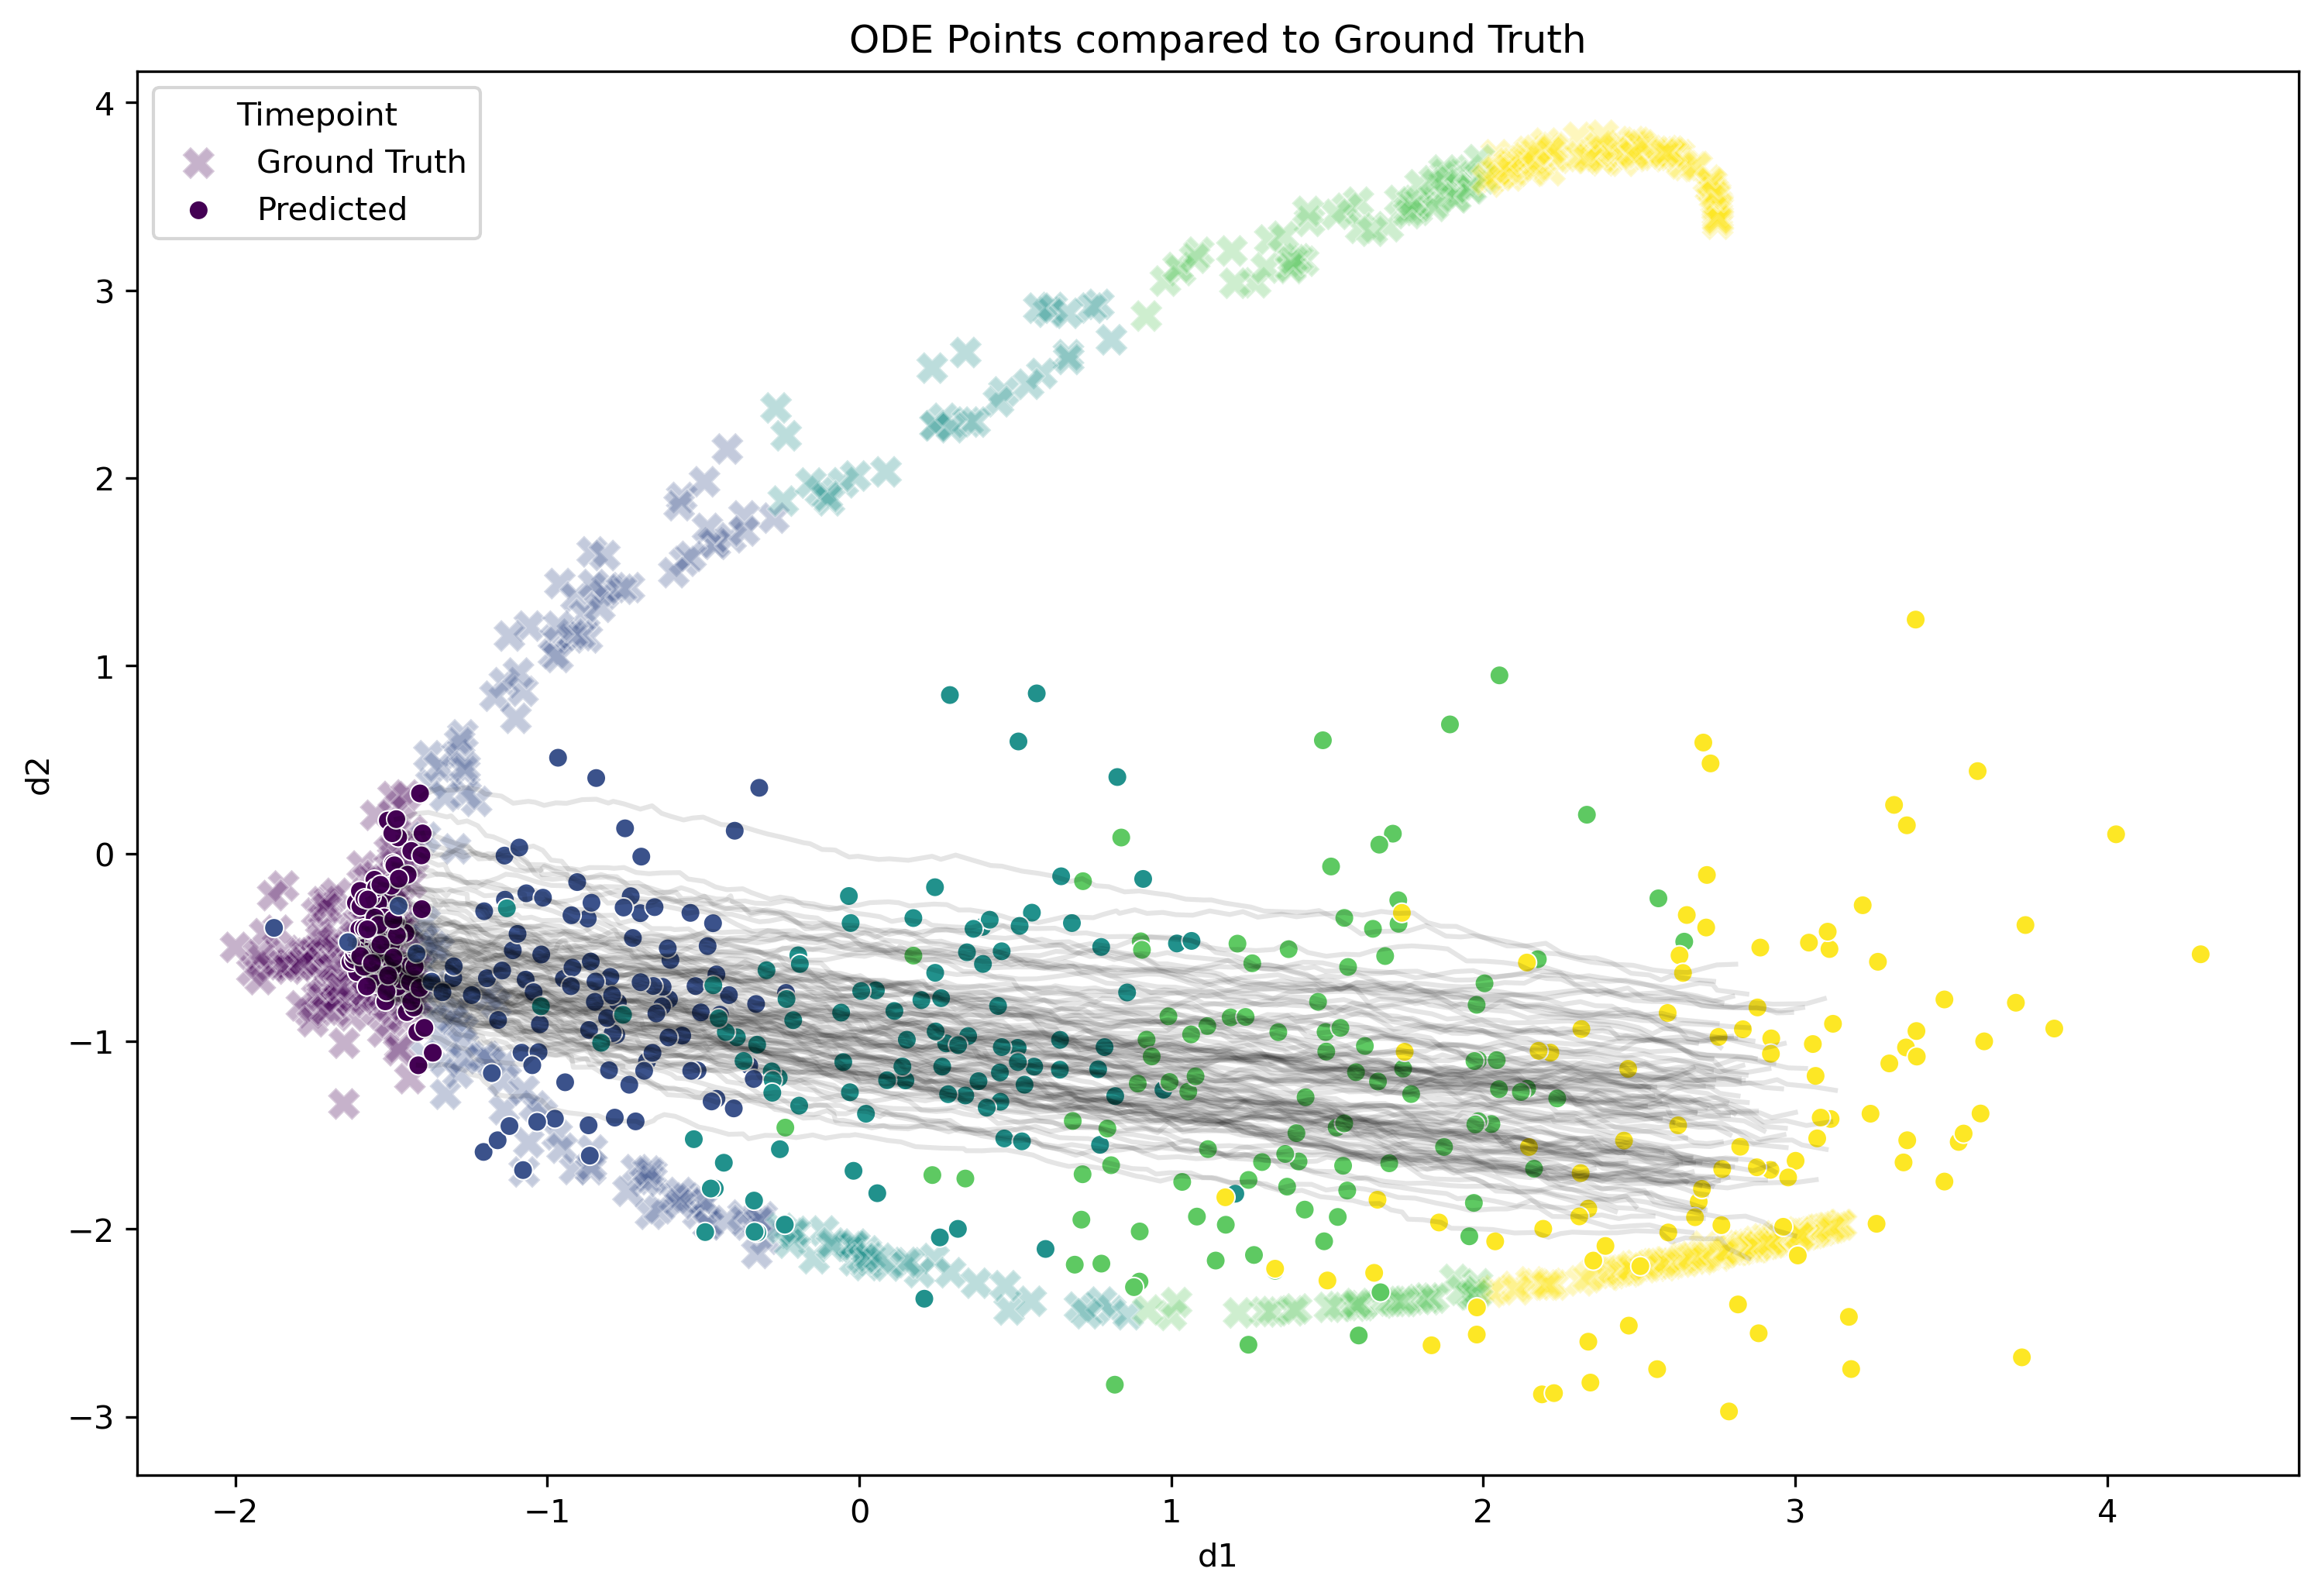

In [ ]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

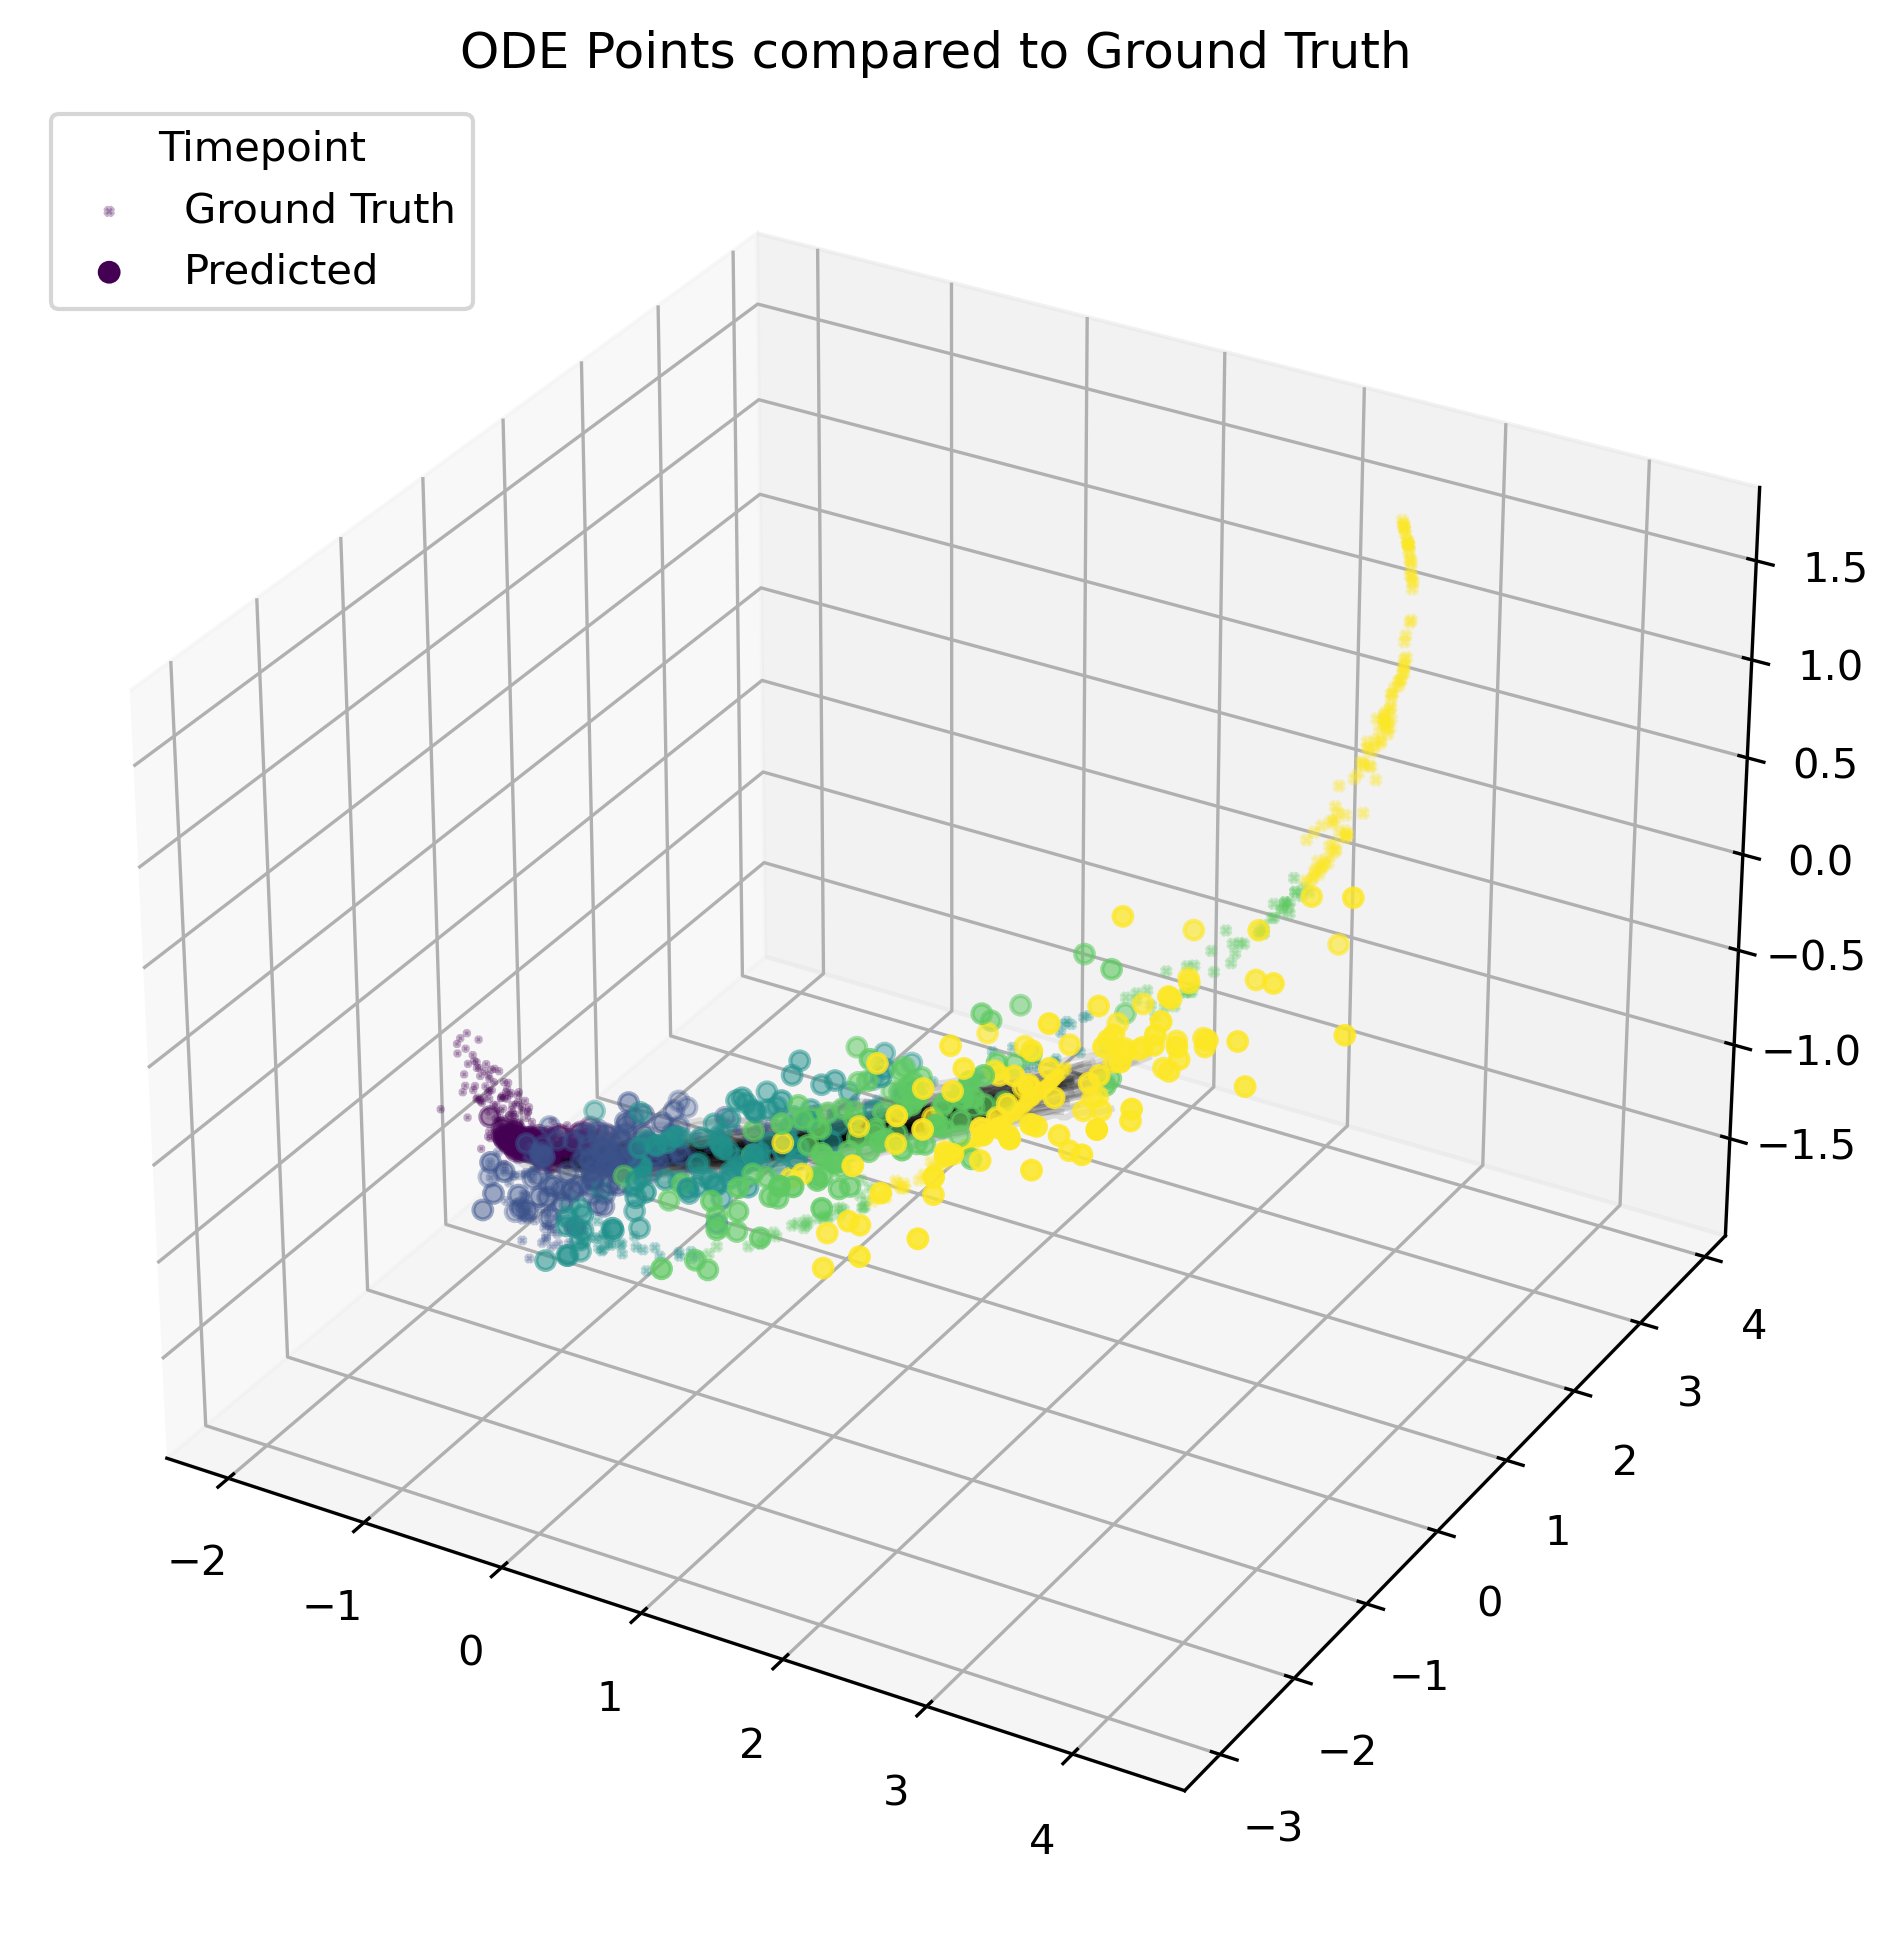

In [ ]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='3d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=True
)

In [ ]:
# saving the trajectories and generated points
#np.save(os.path.join(exp_dir,'trajectories_leave{}.npy'.format(hold_out)),trajectories)
#np.save(os.path.join(exp_dir,'generated_leave{}.npy'.format(hold_out)),generated)

In [ ]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [ ]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)